# Preliminary

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from importlib import reload

In [2]:
import fca_interp as fcai

In [443]:
def delete_nocontrib_concepts(fm, conj_form=True, eps=None):
    improv_metric = 'y_pred'
    to_see = range(len(fm._concepts)-1,0,-1)
    for c_id in to_see:
        c = fm.get_concept_by_id(c_id)
        if len(c.get_extent())==0:
            fm.delete_concept(c_id)
            continue

        upns = c._up_neighbs
        if len(upns)>0:
            flg = len(upns)
            for upn_id in upns:
                upn = fm.get_concept_by_id(upn_id)
                upn_val = dict({'y_true':upn._y_true_mean, 'y_pred':upn._y_pred_mean}, **upn._metrics)[improv_metric]
                c_val = dict({'y_true':c._y_true_mean, 'y_pred':c._y_pred_mean}, **c._metrics)[improv_metric]
                if eps is not None:
                    if upn_val is None:
                        continue
                    if abs(c_val-upn_val)<=eps:
                        flg = 0 if conj_form else flg-1
                        if flg == 0:
                            break
                else:
                    if not (c_val==upn_val and c_val in [0,1]):# or abs(c_val-upn_val)<=eps:
                        #flg = False
                        flg = 0 if conj_form else flg-1
                        if flg == 0:
                            break

            if flg==0:
                #print(c_id, upn_id)
                fm.delete_concept(c_id)

In [19]:
def print_contributions(fm):
    asr = []
    itr = 1
    for c in sorted(fm._concepts, key=lambda c: c._idx):
        if c._y_pred_mean is None:
                continue
        for un_idx in c._up_neighbs:
            un = fm.get_concept_by_id(un_idx)
            new_int = [i for i in c._intent if i not in un._intent]
            d = c._y_pred_mean-un._y_pred_mean
            asr.append((new_int, un._intent, d))
            print(f"{itr}) {c._idx}->{un_idx}: c({', '.join(new_int)} | {', '.join(un._intent)}) -> {d:.2f}")
            itr += 1
        #if len(c._extent)>0:
        #    print(f"{c._idx}: {', '.join(c._intent) if len(c._intent)>0 else '()'} => {c._y_pred_mean:.2f}")    
    return asr

In [183]:
def plot_concepts_as_hypotheses(concepts, sort_by_idx=True):
    if type(concepts) not in [list, tuple]:
        concepts = [concepts]
    concepts = [c for c in concepts if c._y_pred_mean is not None]
    if sort_by_idx:
        concepts = sorted(concepts, key=lambda c: c._idx)
    for c in concepts:
        print(f"{c._idx}: {','.join(c._intent if c._intent is not None else [])} -> {c._y_pred_mean:.2f}")

In [368]:
def plot_base_pos_neg_hypotheses(fm, base_pred=None):
    base_pred = fm.get_concept_by_id(0)._y_pred_mean if base_pred is None else base_pred
    concepts = [c for c in fm._concepts if c._y_pred_mean is not None]
    print('-------------------------')
    print('-----Base hypothesis-----')
    print('-------------------------')
    #plot_concepts_as_hypotheses(fm.get_concept_by_id(0))
    print(f'0: _ -> {base_pred:.2f}')
    print()
    print('-------------------------')
    print('---Positive hypotheses---')
    print('-------------------------')
    plot_concepts_as_hypotheses(sorted([c for c in concepts if c._y_pred_mean>base_pred], key=lambda c: c._y_pred_mean))
    print()
    print('-------------------------')
    print('---Negative hypotheses---')
    print('-------------------------')
    plot_concepts_as_hypotheses(sorted([c for c in concepts if c._y_pred_mean<base_pred], key=lambda c: -c._y_pred_mean))    

In [152]:
def delete_lower_neighbs(fm, c):
    lns = [fm.get_concept_by_id(ln_id) for ln_id in c._low_neighbs]
    for ln in lns:
        delete_lower_neighbs(fm, ln)
    fm.delete_concept(c._idx)

In [153]:
def delete_all_lower_neighbs_downwise(fm, min_y=0, max_y=1):
    idx = 0
    while len([c for c in fm._concepts if c._y_pred_mean is not None and 
               round(c._y_pred_mean,2) in [min_y,max_y] and len(c._low_neighbs)>0])>0:
        #print(idx)
        c = [c for c in fm._concepts if c._y_pred_mean is not None and 
             round(c._y_pred_mean,2) in [min_y,max_y] and len(c._low_neighbs)>0][0]
        delete_lower_neighbs(fm, fm.get_concept_by_id(list(c._low_neighbs)[0]))
        idx += 1    

# Mango DataSet

In [155]:
mango_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'mango.csv'), index_col=0)
print(mango_ds.shape)
mango_ds.head()

(8, 5)


,color,firm,smooth,form,fruit
title,,,,,
apple,yellow,False,True,round,True
grapefruit,yellow,False,False,round,True
kiwi,green,False,False,oval,True
plum,blue,False,True,oval,True
toy cube,green,True,True,cubic,False


In [156]:
mango_bin_ds = mango_ds.copy()
for f in mango_bin_ds.columns:
    if mango_bin_ds[f].nunique()>2:
        for v in mango_bin_ds[f].unique():
            #mango_bin_ds[f"{f}__{v}"] = mango_bin_ds[f]==v
            mango_bin_ds[f"{v}"] = mango_bin_ds[f]==v
        mango_bin_ds = mango_bin_ds.drop(f,1)
print(mango_bin_ds.shape)
mango_bin_ds.head()

(8, 10)


,firm,smooth,fruit,yellow,green,blue,white,round,oval,cubic
title,,,,,,,,,,
apple,False,True,True,True,False,False,False,True,False,False
grapefruit,False,False,True,True,False,False,False,True,False,False
kiwi,False,False,True,False,True,False,False,False,True,False
plum,False,True,True,False,False,True,False,False,True,False
toy cube,True,True,False,False,True,False,False,False,False,True


In [157]:
y_feat = 'fruit'
s = mango_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)
y_train = mango_ds[y_feat].astype(int)

train_pool = Pool(mango_ds.drop(y_feat,1), y_train, cat_features=cat_feats)
bb = CatBoostClassifier(random_seed=42)
bb.fit(train_pool, verbose=False, plot=False)

train_preds = bb.predict(train_pool)
train_preds_proba = bb.predict_proba(train_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(),  'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train'])
metrics_ds

,metrics,train
0,accuracy_score,0.875000
1,precision_score,0.833333
2,recall_score,1.000000
3,y_mean,0.625000


In [196]:
fcai = reload(fcai)

In [197]:
%%time
cntx_mango = fcai.Context(mango_bin_ds.drop(y_feat,1),y_true=y_train, y_pred=train_preds)
fm_mango = fcai.FormalManager(cntx_mango, ds_obj=None, task_type='binary classification')
fm_mango.construct_concepts(use_tqdm=False)
fm_mango.construct_lattice(use_tqdm=False)

CPU times: user 48.8 ms, sys: 4.17 ms, total: 52.9 ms
Wall time: 51.4 ms


/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



In [198]:
fig = fm_mango.get_plotly_fig(level_sort='mean', sort_by='y_true',
                        y_precision=2, title='Mango Dataset Concept Lattice', cbar_title='Mean fruit prediction',
                        color_by='y_pred',)

In [199]:
fig.show()

In [200]:
len(fm_mango._concepts)

18

In [201]:
delete_all_lower_neighbs_downwise(fm_mango)

In [202]:
len(fm_mango._concepts)

11

In [203]:
for c in sorted(fm_mango._concepts, key=lambda c: c._idx):
    if c._y_pred_mean is None:
        continue
    print(f"{c._idx}: {','.join(c._intent)} -> {c._y_pred_mean:.2f}")

0:  -> 0.75
1: green -> 0.67
2: oval -> 0.75
3: round -> 1.00
4: smooth -> 0.60
5: white -> 0.50
6: firm,smooth -> 0.00
7: green,oval -> 1.00
8: smooth,green -> 0.50
9: smooth,oval -> 0.67
10: smooth,blue,oval -> 1.00


In [204]:
fig1 = fm_mango.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Mango Dataset Concept Lattice', cbar_title='Mean fruit prediction',
                        color_by='y_pred',)

In [205]:
fig1.show()

In [206]:
for c in sorted(fm_mango._concepts, key=lambda c: c._idx):
    print(f"{c._idx}: {','.join(c._intent)} -> {c._y_pred_mean:.2f}")

0:  -> 0.75
1: green -> 0.67
2: oval -> 0.75
3: round -> 1.00
4: smooth -> 0.60
5: white -> 0.50
6: firm,smooth -> 0.00
7: green,oval -> 1.00
8: smooth,green -> 0.50
9: smooth,oval -> 0.67
10: smooth,blue,oval -> 1.00


In [207]:
improv_metric = 'y_pred'
to_see = range(len(fm_mango._concepts)-1,0,-1)
for c_id in to_see:
    c = fm_mango.get_concept_by_id(c_id)
    if len(c.get_extent())==0:
        fm_mango.delete_concept(c_id)
        continue

    lns = c._low_neighbs
    c_val = dict({'y_true':c._y_true_mean, 'y_pred':c._y_pred_mean}, **c._metrics)[improv_metric]
    if len(lns)==0 and c_val not in [0,1]:
        fm_mango.delete_concept(c_id)

fm_mango.construct_lattice()

In [208]:
fig2 = fm_mango.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Mango Dataset Concept Lattice', cbar_title='Mean fruit prediction',
                        color_by='y_pred',)

In [209]:
fig2.show()

In [210]:
asr = print_contributions(fm_mango);

1) 1->0: c(green | ) -> -0.08
2) 2->0: c(oval | ) -> 0.00
3) 3->0: c(round | ) -> 0.25
4) 4->0: c(smooth | ) -> -0.15
5) 5->4: c(firm | smooth) -> -0.60
6) 6->1: c(oval | green) -> 0.33
7) 6->2: c(green | oval) -> 0.25
8) 7->2: c(smooth | oval) -> -0.08
9) 7->4: c(oval | smooth) -> 0.07
10) 8->7: c(blue | smooth, oval) -> 0.33


/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [211]:
plot_concepts_as_hypotheses(fm_mango._concepts)

0:  -> 0.75
1: green -> 0.67
2: oval -> 0.75
3: round -> 1.00
4: smooth -> 0.60
5: firm,smooth -> 0.00
6: green,oval -> 1.00
7: smooth,oval -> 0.67
8: smooth,blue,oval -> 1.00


# Monotone lattice

* 0:  -> 0.75
* 1: green -> 0.67
* 2: oval -> 0.75
* 3: round -> 1.00
* 4: smooth -> 0.60
* 5: firm,smooth -> 0.00
* 6: green,oval -> 1.00
* 7: smooth,oval -> 0.67
* 8: smooth,blue,oval -> 1.00

In [212]:
def get_context_by_concepts(fm, base_ds):
    agg_ds = pd.DataFrame()
    for f in [c._intent[0] for c in fm._concepts if len(c._intent)==1]:
        agg_ds[f] = base_ds[f]
    for fs in [c._intent for c in fm._concepts if len(c._intent)>1]:
        agg_ds['&'.join(fs)] = base_ds[fs].sum(1)==len(fs)
    return agg_ds

In [213]:
mango_agg_bin_ds = get_context_by_concepts(fm_mango, mango_bin_ds)
mango_agg_bin_ds.head()

,green,oval,smooth,round,smooth&blue&oval,firm&smooth,smooth&oval,green&oval
title,,,,,,,,
apple,False,False,True,True,False,False,False,False
grapefruit,False,False,False,True,False,False,False,False
kiwi,True,True,False,False,False,False,False,True
plum,False,True,True,False,True,False,True,False
toy cube,True,False,True,False,False,True,False,False


In [214]:
mango_agg_bin_ds_alt = ~mango_agg_bin_ds

In [223]:
fcai = reload(fcai)

In [224]:
%%time
cntx_mango_mon = fcai.Context(mango_agg_bin_ds_alt,y_true=y_train, y_pred=train_preds)
fm_mango_mon = fcai.FormalManager(cntx_mango_mon, ds_obj=None, task_type='binary classification')
fm_mango_mon.construct_concepts(use_tqdm=False, is_monotonic=True)
fm_mango_mon.construct_lattice(use_tqdm=False)

CPU times: user 92.9 ms, sys: 162 µs, total: 93 ms
Wall time: 90.5 ms


/home/egor/Yandex.Disk/Evolving/uni2/uni/course_work/FCA_BB_interpret/lib/fca_interp.py:404: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



In [225]:
fig = fm_mango_mon.get_plotly_fig(level_sort='mean', sort_by='y_true',
                        y_precision=2, title='Mango Dataset Concept Lattice', cbar_title='Mean fruit prediction',
                        color_by='y_pred',)

In [226]:
fig.show()

In [228]:
delete_all_lower_neighbs_downwise(fm_mango_mon)

In [229]:
fig = fm_mango_mon.get_plotly_fig(level_sort='mean', sort_by='y_true',
                        y_precision=2, title='Mango Dataset Concept Lattice', cbar_title='Mean fruit prediction',
                        color_by='y_pred',)

In [230]:
fig.show()

In [232]:
plot_concepts_as_hypotheses(fm_mango_mon._concepts)

1: firm&smooth -> 0.00
2: green&oval -> 1.00
3: round -> 1.00
4: smooth&blue&oval -> 1.00


In [240]:
plot_base_pos_neg_hypotheses(fm_mango_mon, base_pred=train_preds.mean())

-------------------------
-----Base hypothesis-----
-------------------------
0: _ -> 0.75

-------------------------
---Positive hypotheses---
-------------------------
2: green&oval -> 1.00
3: round -> 1.00
4: smooth&blue&oval -> 1.00

-------------------------
---Negative hypotheses---
-------------------------
1: firm&smooth -> 0.00


# Bank DataSet

In [241]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [242]:
y_feat = 'y'
s = bank_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)

X_train, X_test, y_train, y_test = train_test_split(bank_ds[cat_feats+real_feats],
                                                    bank_ds[y_feat].apply(lambda x: {'no':0,'yes':1}[x]),
                                                   random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_feats)
test_pool = Pool(X_test, y_test, cat_features=cat_feats)
bb = CatBoostClassifier(random_seed=42)
bb.fit(train_pool, verbose=False, plot=False)

train_preds, test_preds = bb.predict(train_pool), bb.predict(test_pool)
train_preds_proba, test_preds_proba = bb.predict_proba(train_pool)[:,1], bb.predict_proba(test_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'test':m(y_test, test_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(), 'test':y_test.mean(), 'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train','test'])
metrics_ds

,metrics,train,test
0,accuracy_score,0.937758,0.905393
1,precision_score,0.838828,0.600000
2,recall_score,0.578283,0.432000
3,y_mean,0.116814,0.110522


# Задача

Найти импликации, гипотезы и ассоциативные правила, которые отражают зависимость целевой переменной $Y$ от конкретных значений признаков и исходных данных $X$.

Для лучшей интерпретабельности желательно использовать как можно меньше признаков и их значений. Для этого нужно отобрать наиболее важные признаки и их наиболее влиятельные значения. Как это сделать? Через Shap.

In [243]:
sv = bb.get_feature_importance(test_pool, type='ShapValues')
expected_value = sv[0,-1]
sv_ds = pd.DataFrame(sv[:,:-1], columns=test_pool.get_feature_names())
sv_ds.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,duration,campaign,pdays,previous
0,-0.031291,-0.028272,0.035948,-0.267942,0.101734,-0.268115,0.287815,-0.323185,-0.132049,-0.030460,-0.318450,-0.020844,-1.178477,-0.127363,0.049373,-0.018233
1,0.127565,0.018116,0.079303,-0.008569,0.096851,0.031259,0.187173,0.168337,0.890014,-0.044830,0.208614,-0.046283,1.976521,0.021740,0.050712,0.346256
2,-0.030689,-0.021500,0.028779,0.006304,0.096207,0.052130,0.282196,-0.105999,-0.113547,-0.046154,0.107670,0.009493,-0.678837,0.034704,0.059806,-0.013104
3,0.031418,-0.033332,0.083075,0.001851,-0.065374,0.046528,-0.630254,-0.083773,-0.128123,-0.081089,-0.146013,0.002586,0.676073,-0.356123,0.025053,-0.038261
4,0.007788,0.058849,0.010468,-0.001448,0.106346,0.037828,0.319354,0.229482,-0.117150,-0.034576,0.018484,-0.047470,0.977713,0.028636,0.043395,-0.037927


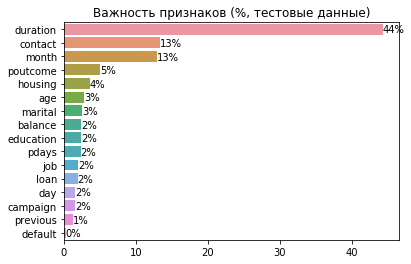

In [244]:
s = sv_ds.abs().median(0).sort_values(ascending=False)
s = s/s.sum()*100
sns.barplot(x=s.values, y=s.index)
for idx, t in enumerate(s.iteritems()):
    plt.text(t[1], idx+0.25, f"{t[1]:.0f}%")
plt.title('Важность признаков (%, тестовые данные)')
plt.show()

In [245]:
bin_funcs = {}

Первые 3 признака сильно лидируют по важности (duration, contact, month). Рассмотрим их более детально.

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



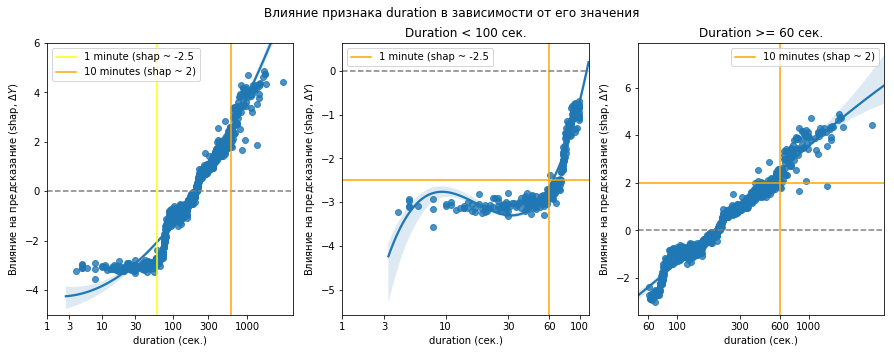

In [39]:
f = 'duration'
cds = pd.DataFrame()
cds[f] = np.log1p(X_test[f])
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,5))
plt.subplot(131)
sns.regplot(x='duration', y=f+'_shap', data=cds, order=2)
xticks = np.array([1, 3,10,30,100,300,1000])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(np.log1p(60), color='yellow', label='1 minute (shap ~ -2.5')
plt.axvline(np.log1p(600), color='orange', label='10 minutes (shap ~ 2)')
plt.legend()
plt.xticks(np.log1p(xticks), xticks)
plt.ylim((-5,6))
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')

plt.subplot(132)
sns.regplot(x='duration', y=f+'_shap', data=cds[cds[f]<np.log1p(100)], order=3)
xticks = np.array([1, 3,10,30,60,100])
plt.axvline(np.log1p(60), color='orange', label='1 minute (shap ~ -2.5')
plt.axhline(-2.5, color='orange')
plt.legend()
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Duration < 100 сек.')

plt.xticks(np.log1p(xticks), xticks)

plt.subplot(133)
sns.regplot(x='duration', y=f+'_shap', data=cds[cds[f]>=np.log1p(60)], order=3)
xticks = np.array([60, 100, 300, 600, 1000])
plt.xticks(np.log1p(xticks), xticks)
plt.axvline(np.log1p(600), color='orange', label='10 minutes (shap ~ 2)')
plt.axhline(2, color='orange')
plt.axhline(0, linestyle='--', color='grey')
plt.legend()
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Duration >= 60 сек.')


plt.suptitle('Влияние признака duration в зависимости от его значения')
plt.show()

In [273]:
def binf_duration(x):
    b = pd.Series()
    b['<1m'] = x<60
    b['>=1m'] = x>=60
    b['>=1.5m'] = x>=100
    b['>=3m'] = x>=180
    b['>=5.5m'] = x>=325
    b['>=16.5m'] = x>=600
    return b.astype(int)

In [279]:
bin_funcs['duration'] = binf_duration

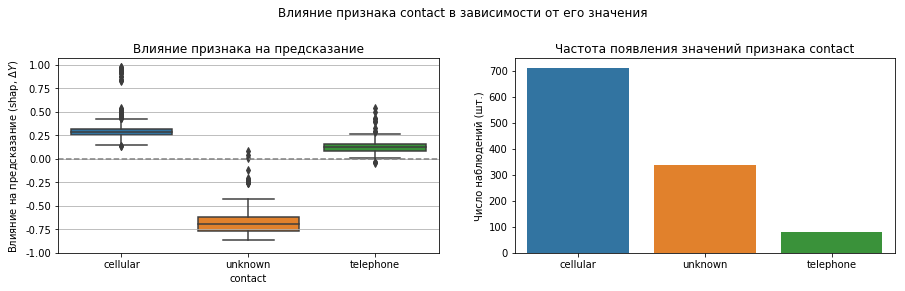

In [280]:
f = 'contact'
cds = pd.DataFrame()
cds[f] = X_test[f]
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,4))
plt.subplot(121)
sns.boxplot(x=f, y=f+'_shap', data=cds)
plt.axhline(0, linestyle='--', color='grey')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Влияние признака на предсказание')
yticks = np.arange(-1,1.1, 0.25)
plt.yticks(yticks, [f"{x:.2f}" for x in yticks])
plt.grid(axis='y')

plt.subplot(122)
s_ = cds[f].value_counts()
#s_ = s_/s_.sum()*100
sns.barplot(x=s_.index, y=s_.values)
plt.title(f'Частота появления значений признака {f}')
plt.ylabel('Число наблюдений (шт.)')

plt.subplots_adjust(top=0.8)
plt.suptitle('Влияние признака contact в зависимости от его значения')
plt.show()

In [281]:
def binf_contact(x):
    b = pd.Series()
    for v in ['cellular','unknown']:
        b[v] = x==v
    return b.astype(int)

In [282]:
bin_funcs['contact'] = binf_contact

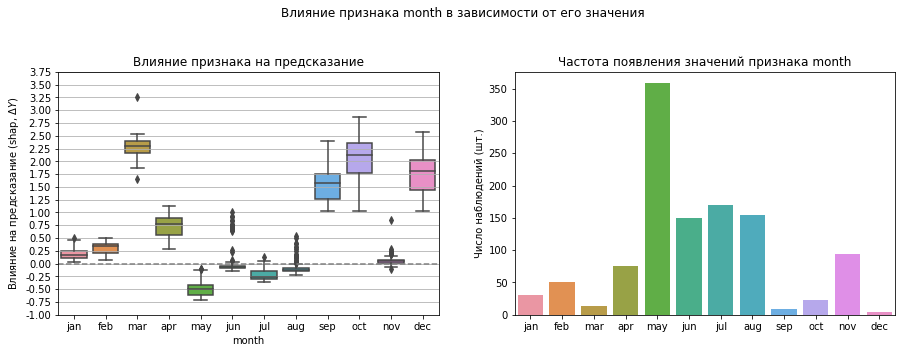

In [283]:
f = 'month'
cds = pd.DataFrame()
cds[f] = X_test[f]
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(x=f, y=f+'_shap', data=cds, order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
plt.axhline(0, linestyle='--', color='grey')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Влияние признака на предсказание')
yticks = np.arange(-1,4,0.25)
plt.yticks(yticks, [f"{x:.2f}" for x in yticks])
plt.grid(axis='y')

plt.subplot(122)
s_ = cds[f].value_counts()
#s_ = s_/s_.sum()*100
s_ = s_.reindex(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
sns.barplot(x=s_.index, y=s_.values)
plt.title(f'Частота появления значений признака {f}')
plt.ylabel('Число наблюдений (шт.)')

plt.subplots_adjust(top=0.8)
plt.suptitle(f'Влияние признака {f} в зависимости от его значения')
plt.show()

In [288]:
def binf_month(x):
    b = pd.Series()
    for v in ['feb', 'mar', 'apr', 'may', 'sep','oct','dec']:
        b[v] = x==v
    return b.astype(int)

In [289]:
bin_funcs['month'] = binf_month

Данные ужасны, но продолжим работу

In [326]:
implications = [('duration__>=1m','duration__>=1.5m'),
                   ('duration__>=1.5m','duration__>=3m'),
                   ('duration__>=3m','duration__>=5.5m'),
                   ('duration__>=5.5m', 'duration__>=16.5m')]

In [476]:
bin_ds = []
for f in tqdm_notebook(s[:3].index):
    cds = pd.concat([bin_funcs[f](x) for x in X_test[f]],1).T
    cds.columns = [f"{f}__{x}" for x in cds.columns]
    bin_ds.append(cds)
bin_ds = pd.concat(bin_ds,1)
bin_ds.index = X_test.index
print(bin_ds.shape)
bin_ds.head()


(1131, 15)


,duration__<1m,duration__>=1m,duration__>=1.5m,duration__>=3m,duration__>=5.5m,duration__>=16.5m,contact__cellular,contact__unknown,month__feb,month__mar,month__apr,month__may,month__sep,month__oct,month__dec
2398,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
800,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0
2288,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
2344,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0
3615,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0


In [477]:
import fca_interp as fcai

In [485]:
fcai = reload(fcai)

In [561]:
bin_ds = bin_ds.astype(bool)

In [562]:
%%time
cntx_bank = fcai.Context(bin_ds,y_true=y_test, y_pred=test_preds)
fm_bank = fcai.FormalManager(cntx_bank, ds_obj=None, task_type='binary classification')
fm_bank.construct_concepts(use_tqdm=False, is_monotonic=False)
fm_bank.construct_lattice(use_tqdm=False)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



CPU times: user 1.06 s, sys: 12.1 ms, total: 1.07 s
Wall time: 1.07 s


/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



In [563]:
#new_concepts = []
for c in fm_bank._concepts:
    intent = c._intent
    for f1, f2 in implications:
        if f1 in intent and f2 in intent:
            intent = [f for f in intent if f!=f1]
    c._intent = intent
#    new_concepts.append(c)
#fm_bank._concepts = new_concepts

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [564]:
fig = fm_bank.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

In [565]:
fig.show()

In [566]:
delete_all_lower_neighbs_downwise(fm_bank)

In [567]:
delete_nocontrib_concepts(fm_bank, conj_form=True, eps=0.05)

In [570]:
improv_metric = 'y_pred'
to_see = range(len(fm_bank._concepts)-1,0,-1)
for c_id in to_see:
    c = fm_bank.get_concept_by_id(c_id)
    if len(c.get_extent())==0:
        fm_bank.delete_concept(c_id)
        continue

    lns = c._low_neighbs
    c_val = dict({'y_true':c._y_true_mean, 'y_pred':c._y_pred_mean}, **c._metrics)[improv_metric]
    if len(lns)==0 and c_val not in [0,1]:
        fm_bank.delete_concept(c_id)
fm_bank.construct_lattice()

In [573]:
fig = fm_bank.get_plotly_fig(level_sort='all', sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

In [574]:
fig.show()

In [576]:
len(fm_bank._concepts)

20

In [577]:
plot_base_pos_neg_hypotheses(fm_bank)

-------------------------
-----Base hypothesis-----
-------------------------
0: _ -> 0.08

-------------------------
---Positive hypotheses---
-------------------------
2: duration__>=16.5m -> 0.51
3: duration__>=5.5m -> 0.25
4: month__mar -> 0.31
6: month__oct -> 0.52
7: duration__>=1.5m,month__dec -> 0.40
8: duration__>=1.5m,month__mar -> 0.57
9: duration__>=1.5m,month__oct -> 0.63
10: duration__>=16.5m,month__dec -> 1.00
11: duration__>=1m,month__sep -> 0.33
12: duration__>=3m,month__dec -> 0.50
13: duration__>=3m,month__oct -> 0.80
14: duration__>=5.5m,contact__cellular -> 0.32
15: duration__>=1.5m,contact__cellular,month__mar -> 0.67
16: duration__>=1m,contact__cellular,month__mar -> 0.40
17: duration__>=3m,contact__cellular,month__mar -> 1.00
18: duration__>=5.5m,contact__cellular,month__may -> 0.17
19: duration__>=5.5m,contact__cellular,month__oct -> 1.00

-------------------------
---Negative hypotheses---
-------------------------
1: duration__<1m -> 0.00
5: month__may -> 0.0

In [578]:
bin_ds_agg = get_context_by_concepts(fm_bank, bin_ds)
print(bin_ds_agg.shape)
bin_ds_agg.head()

(1131, 19)


,duration__>=5.5m,duration__>=16.5m,duration__<1m,month__oct,month__mar,month__may,duration__>=1.5m&contact__cellular&month__mar,duration__>=1.5m&month__dec,duration__>=1.5m&month__mar,duration__>=3m&month__oct,duration__>=3m&month__dec,duration__>=1.5m&month__oct,duration__>=3m&contact__cellular&month__mar,duration__>=1m&month__sep,duration__>=1m&contact__cellular&month__mar,duration__>=5.5m&contact__cellular,duration__>=16.5m&month__dec,duration__>=5.5m&contact__cellular&month__oct,duration__>=5.5m&contact__cellular&month__may
2398,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
800,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2288,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2344,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3615,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [579]:
bin_ds_agg_alt = ~bin_ds_agg

In [665]:
%%time
cntx_bank_mon = fcai.Context(bin_ds_agg_alt,y_true=y_test, y_pred=test_preds)
fm_bank_mon = fcai.FormalManager(cntx_bank_mon, ds_obj=None, task_type='binary classification')
fm_bank_mon.construct_concepts(use_tqdm=False, is_monotonic=True )
#fm_bank_mon.construct_lattice(use_tqdm=False)

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/s

CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 19.2 s


In [666]:
border_hyps = [c for c in fm_bank_mon._concepts if c._y_pred_mean in [0,1]]
border_hyps = sorted(border_hyps, key=lambda c: '|'.join(c._intent))

In [667]:
for bh in tqdm_notebook(border_hyps):
    to_del_hyps = [c for c in fm_bank_mon._concepts if all([m in c._intent for m in bh._intent]) and c!=bh]
    fm_bank_mon._concepts = [c for c in fm_bank_mon._concepts if c not in to_del_hyps]

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [668]:
idx_map = {c_._idx: i for i, c_ in
           enumerate(sorted(fm_bank_mon._concepts, key=lambda c_: (len(c_.get_intent()), ','.join(c_.get_intent()))))
          }

In [669]:
for c in fm_bank_mon._concepts:
    c._idx = idx_map[c._idx]

In [670]:
fm_bank_mon._top_concept = fm_bank_mon.get_concept_by_id(0)

In [671]:
fm_bank_mon.construct_lattice(use_tqdm=False)

In [676]:
fig = fm_bank_mon.get_plotly_fig(level_sort=2, sort_by='y_pred',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Mean Prediction',
                        color_by='y_pred',)

/home/egor/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning:

Mean of empty slice.

/home/egor/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [677]:
fig.show()

In [678]:
plot_base_pos_neg_hypotheses(fm_bank_mon, base_pred=test_preds.mean())

-------------------------
-----Base hypothesis-----
-------------------------
0: _ -> 0.08

-------------------------
---Positive hypotheses---
-------------------------
2: duration__>=16.5m&month__dec -> 1.00
3: duration__>=1m&month__sep -> 0.33
4: duration__>=3m&contact__cellular&month__mar -> 1.00
5: duration__>=5.5m&contact__cellular&month__may -> 0.17
6: duration__>=5.5m&contact__cellular&month__oct -> 1.00
7: duration__>=1m&month__sep,duration__>=5.5m&contact__cellular&month__may -> 0.20

-------------------------
---Negative hypotheses---
-------------------------
1: duration__<1m -> 0.00
8: month__may,duration__>=5.5m&contact__cellular&month__may -> 0.02
9: month__may,duration__>=1m&month__sep,duration__>=5.5m&contact__cellular&month__may -> 0.03


-----Base hypothesis-----
-------------------------
0. : _ -> 0.08


---Positive hypotheses---
-------------------------
2. : duration__>=16.5m & month__dec -> 1.00
3. : duration__>=1m & month__sep -> 0.33
4. : duration__>=3m & contact__cellular & month__mar -> 1.00
5. : duration__>=5.5m & contact__cellular & month__may -> 0.17
6. : duration__>=5.5m & contact__cellular & month__oct -> 1.00
7. : duration__>=1m & month__sep OR duration__>=5.5m & contact__cellular & month__may -> 0.20


---Negative hypotheses---
-------------------------
1. : duration__<1m -> 0.00
8. : month__may -> 0.02
9. : month__may OR (duration__>=1m & month__sep) -> 0.03